# Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

from torch import nn
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

from numpy import asarray
from PIL import Image

# Helper Functions

In [2]:
# Helper to convert given labels to 0-indexed (necessary for cleanlab and various ML processes).
def labels_to_zeroidx(labels):
    unique_labels = set(labels)
    label2idx = dict(zip(unique_labels, range(len(unique_labels))))
    return [label2idx[label] for label in labels]

# Helper to get image data and transform into numpy tensor.
def get_image_data(df, path_to_imgs):
    # Our images are black and white, 60x60 pixels.
    img_width, img_height = 60, 60
    img_data = np.empty([len(df), img_width*img_height])
    
    # Iterate over each image name in the csv file
    # - Read image, get pixel values, transform, reshape for PyTorch nn
    img_names = df['img']
    for i, img_name in enumerate(img_names):
        img = Image.open(path_to_imgs+img_name)
        data = np.array(img.getdata()).astype("float32")
        data /= 255.0 # Transform the pixels to 0 and 1
        img_data[i] = data
    img_data = img_data.astype("float32")
    img_data = img_data.reshape(len(df), 1, 60, 60)  # reshape into [N, C, H, W] for PyTorch
    return img_data

# Data

In [3]:
# Read in label csvs. 
# Fill in TODO with path to files.
path_to_train_csv = "train-labels.csv"
path_to_test_csv = "val-labels.csv"
train_df = pd.read_csv(path_to_train_csv)
test_df = pd.read_csv(path_to_test_csv)

# Training data.
# Fill in TODO with path to images.
path_to_train_imgs = 'train/'
X_train = get_image_data(train_df, path_to_train_imgs)
# Convert given labels to 0-indexes labels.
y_train = np.array(labels_to_zeroidx(train_df['label']))

# Test data.
# Fill in TODO with path to images.
path_to_test_imgs = 'val/'
X_test = get_image_data(test_df, path_to_test_imgs)

# Baseline Model

In [4]:
train_df.label.unique(

)

array(['c', 'h', 'y', 'p', 'j', 'a', 'k', '3', 'q', '5', 'g', 'w', '2',
       '4', 'v', 'z', 'm', 'l', 'd', 'f', 's', 'x', '7', 't', 'n', '8',
       'e', 'o', 'r', 'u', 'b', '6', 'i'], dtype=object)

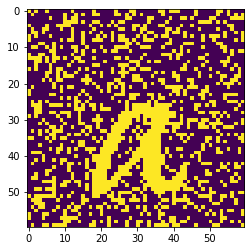

In [5]:
plt.imshow(X_train[5].reshape(60, 60, 1))

In [4]:
# Basic neural net.
# Taken from cleanlab image tutorial: https://docs.cleanlab.ai/stable/tutorials/image.html
class ClassifierModule(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 6, 3),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Linear(128, 33),
            nn.Softmax(dim=-1),
        )

    def forward(self, X):
        X = self.cnn(X)
        X = self.out(X)
        return X

In [5]:
# To ensure scikit-learn compatibility (necessary for some cleanlab methods)
#  we adapt the PyTorch neural net using skorch.
model_skorch = NeuralNetClassifier(ClassifierModule)

# Fit model to train data and score on test!
model_skorch.fit(X_train, y_train)

# Predict to get submission.
preds = model_skorch.predict(X_test)

/usr/local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.4839       0.0771        3.4442  3.0213
      2        3.3586       0.1425        3.3149  2.8818
      3        3.1063       0.2637        3.0076  3.1198
      4        2.7173       0.3562        2.6954  3.1553
      5        2.4011       0.4274        2.4949  3.2858
      6        2.1748       0.4716        2.3595  3.2343
      7        2.0002       0.5114        2.2686  3.3558
      8        1.8561       0.5385        2.2015  3.4019
      9        1.7303       0.5561        2.1540  5.1551
     10        1.6164       0.5657        2.1185  5.7436


# Get out-of-sample predicted probabilities

In [6]:
# Get out-of-sample predicted probabilities for training data to pass into cleanlab.
pred_probs = cross_val_predict(model_skorch,X_train,y_train,method="predict_proba")
# Cross validation accuracy on training data.
cross_val_preds = np.argmax(pred_probs, axis=1)
acc = accuracy_score(y_train, cross_val_preds)
acc

/usr/local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.4900       0.0578        3.4571  2.9662
      2        3.3786       0.1030        3.3819  3.0101
      3        3.2435       0.1502        3.2556  2.6175
      4        3.0386       0.2126        3.0500  2.6284
      5        2.7691       0.2824        2.8170  2.5305
      6        2.5002       0.3336        2.6181  2.4979
      7        2.2746       0.3807        2.4801  3.0961
      8        2.0906       0.4219        2.3818  3.3760
      9        1.9335       0.4458        2.3141  2.9809
     10        1.7925       0.4678        2.2660  2.6018


/usr/local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.5044       0.0532        3.4781  3.0351
      2        3.4044       0.1037        3.3897  3.0424
      3        3.2545       0.1894        3.2194  2.4354
      4        2.9802       0.2711        2.9233  2.4052
      5        2.6693       0.3482        2.6652  2.4599
      6        2.4134       0.4013        2.5111  2.4279
      7        2.2205       0.4439        2.4091  2.4113
      8        2.0665       0.4764        2.3348  2.5683
      9        1.9339       0.4957        2.2790  2.9049
     10        1.8130       0.5083        2.2375  2.8343


/usr/local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.4730       0.0538        3.4606  3.2672
      2        3.2951       0.0963        3.2628  2.4927
      3        2.9996       0.2664        2.9399  2.2947
      4        2.7182       0.3216        2.7521  3.1625
      5        2.4961       0.3781        2.6129  3.9436
      6        2.3168       0.4040        2.5109  3.8661
      7        2.1654       0.4346        2.4338  4.0365
      8        2.0314       0.4598        2.3706  3.5627
      9        1.9081       0.4751        2.3181  2.4744
     10        1.7912       0.4897        2.2781  2.4317


/usr/local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.4646       0.0458        3.4991  2.5229
      2        3.2707       0.1130        3.2408  2.6884
      3        2.9550       0.2771        2.8872  2.2284
      4        2.6295       0.3548        2.6601  2.2464
      5        2.3852       0.4153        2.5194  2.3109
      6        2.1977       0.4512        2.4151  2.3096
      7        2.0409       0.4837        2.3333  2.2834
      8        1.9033       0.5083        2.2746  2.3092
      9        1.7776       0.5276        2.2298  3.5115
     10        1.6607       0.5422        2.1968  4.3143


/usr/local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.4966       0.0365        3.4894  3.8904
      2        3.4003       0.0605        3.4446  3.9457
      3        3.2391       0.1256        3.2752  3.9453
      4        2.9868       0.2113        3.0654  2.5871
      5        2.7111       0.2771        2.8748  2.3966
      6        2.4741       0.3329        2.7197  2.4068
      7        2.2754       0.3821        2.5974  2.3775
      8        2.1032       0.4239        2.5010  2.3734
      9        1.9489       0.4532        2.4279  2.4112
     10        1.8079       0.4711        2.3727  2.4199


0.49181025313763027

# Find Outliers

In [20]:
from cleanlab.outlier import OutOfDistribution
from cleanlab.rank import find_top_issues

# Use To get outlier scores for train_data using 
#  predicted class probabilities (from a trained classifier) 
#  and given class labels
# Note: all of these are not necessarily outliers. You'll need to improve model performance to get better 
# outlier preditions.
ood = OutOfDistribution()
labels = y_train
ood_scores = ood.fit_score(pred_probs=pred_probs, labels=labels)
ood_idx = find_top_issues(ood_scores, top=300)

# Show the top 5.
top_ood = train_df.iloc[ood_idx][:5]
for img in top_ood['img']:
    display(Image.open(path_to_train_imgs+img))

NameError: name 'pred_probs' is not defined

# Find Label Issues

Given Label: 2


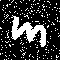

Given Label: 2


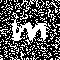

Given Label: j


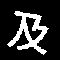

Given Label: j


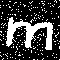

Given Label: x


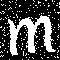

In [8]:
from cleanlab.filter import find_label_issues

# Compute label issues and get their indices.
# Note: all of these are not necessarily label errors. You'll need to improve model performance to get better 
# label preditions.
labels = y_train
issues_idx = find_label_issues(labels=labels, pred_probs=pred_probs, return_indices_ranked_by='self_confidence')

# Show top 5.
for idx in issues_idx[:5]:
    row = train_df.iloc[idx]
    given_label = row['label']
    print(f"Given Label: {given_label}")
    display(Image.open(path_to_train_imgs+row['img']))

# Train a Better Model!

Note: due to the randomness of neural nets, this may decrease, increase, or not change the model performance. 


In [9]:
# Combine outliers and label issues (some overlap).
all_issues_idx = np.union1d(ood_idx, issues_idx)

# Drop all issues from training data.
X_train_clean = np.delete(X_train, all_issues_idx, axis=0)
y_train_clean = np.delete(y_train, all_issues_idx, axis=0)

#Re-train model on data with issues removed.
model_skorch = NeuralNetClassifier(ClassifierModule)
model_skorch.fit(X_train_clean, y_train_clean)

# Predict to get submission.
preds = model_skorch.predict(X_test)

/usr/local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        3.4749       0.0596        3.4627  12.6152
      2        3.3101       0.1708        3.2437  3.8359
      3        2.9968       0.2900        2.8569  3.5849
      4        2.4612       0.4142        2.3706  3.0567
      5        1.9235       0.5188        1.9672  2.9142
      6        1.5205       0.5948        1.6865  2.9341
      7        1.2438       0.6438        1.5172  2.6860
      8        1.0485       0.6797        1.4007  2.4839
      9        0.9027       0.7092        1.3133  1.9900
     10        0.7881       0.7296        1.2473  2.1116


# Food for Thought

- The basic NN classifier used to find the `pred_probs` was not very accurate - improving this classifier might improve quality of issues and outliers found, too.
- Here we just dropped all of the issues and outliers, what else could you do?
- Other useful modules:
    - [cleanlab.classification](https://github.com/cleanlab/cleanlab/blob/master/cleanlab/classification.py)
- Resources:
    - [GitHub](https://github.com/cleanlab/cleanlab)
    - [Docs](https://docs.cleanlab.ai/stable/index.html)
    
